# Transfer Learning, Adversarial Attacks, Deep Network Visualization

In this notebook, we will continue working with images using neural networks.  
Firstly, we'll explore how to use minimal computational resources to train a model for solving a new task when you already have a model for another task.  
Then, we'll take a look at how it's possible to confuse neural networks in just one step on some examples. Towards the end of the seminar, we will visualize the workings of convolutional networks.

### Agenda
1. Explore transfer learning using the example of fine-tuning ResNet.
2. Study adversarial attacks using the example of Fast Gradient Sign Attack.
3. Visualize the layers of a convolutional network using Shapley Additive Explanations.


In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

## 1. Transfer Learning Using ResNet Fine-Tuning

In this section, we will learn how to quickly train a neural network for a complex image classification task.
Specifically, we will train the neural network to classify cats and dogs.

### Data

Let's download the dataset, remove a couple of corrupted images, and prepare the loaders.


In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq kagglecatsanddogs_5340.zip
!rm -rf PetImages/Cat/666.jpg PetImages/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2024-01-26 06:38:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.252.210, 2600:1417:3f:1380::317f, 2600:1417:3f:1391::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.252.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   133MB/s    in 5.6s    

2024-01-26 06:38:52 (142 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

Let's look how the images look like


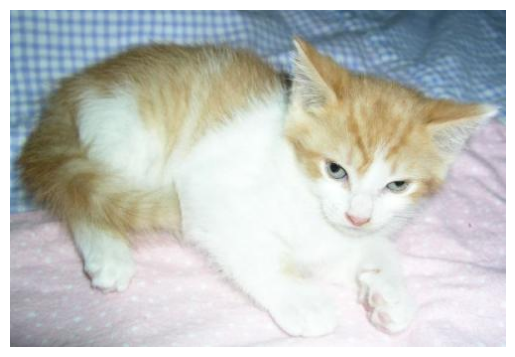

In [4]:
file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file));

### Fine-tuning

Cats and dogs are good, but training a model that performs well on this dataset can be very time-consuming...

However, the images we are exploring today happen to be very similar to the images from the vast ImageNet dataset. The task we'll be looking at today is called Transfer Learning. We are indeed transferring knowledge—from a network that performs well on one dataset (ImageNet) to another dataset (Cats vs Dogs).

#### Load a pre-trained network

The `torchvision` library not only implements a large number of models (various ResNets, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet, etc.) but also provides pre-trained checkpoints for these models on ImageNet. However, for the Cats vs Dogs dataset, this luxury is not available...


In [5]:
%pip install pytorch_lightning
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 65.3 MB/s eta 0:00:00


In [6]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [7]:
model = resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In the transfer learning task, we replace the last layer of the neural network with a linear layer having two outputs, and we freeze the weights of the other layers.


In [13]:
class CatsVSDogsResnet(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.pretrained = pretrained

        if pretrained:
            # <YOUR CODE HERE>
            self.model = resnet18(pretrained=True)
            self.model.fc = nn.Identity()
            self.classifier = nn.Linear(512, 2)
            self.optimizer = torch.optim.Adam(self.classifier.parameters())
        else:
            # <YOUR CODE HERE>
            self.model = resnet18(pretrained=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, 2)
            self.optimizer = torch.optim.Adam(self.model.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        if self.pretrained:
            # <YOUR CODE HERE>
            with torch.no_grad():
                features = self.model(x)
            preds = self.classifier(features)
        else:
            # <YOUR CODE HERE>
            preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

Let's start transfer learning!


In [14]:
cats_vs_dogs_pretrained = CatsVSDogsResnet(pretrained=True)

trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | classifier | Linear           | 1.0 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


After just one epoch, we achieve acceptable quality! Let's see what happens if we train ResNet from scratch.


In [15]:
cats_vs_dogs = CatsVSDogsResnet(pretrained=False)

trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cats_vs_dogs, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


As we can see, the neural network converges very quickly on transfer learning. Much faster than when initialized from scratch. It can be confidently stated that transfer learning is a very useful technique.


## 2. Exploring Adversarial Attacks Using Fast Gradient Sign Attack

Things like attacks on neural networks are crucial to consider in development. There are many methods for both generating and defending against them. Today, we will explore basic concepts to provide an understanding of what's happening.

We can define an adversarial attack as the generation of an example that is indistinguishable by the human eye from a real one, but the neural network will be VERY confident that this example belongs to a different class. Now, we will try to generate such an image of a dog that the neural network will be confident it's a cat.

Today, we will look at an example of the Fast Gradient Sign Attack (FGSM, why there's an M at the end — who knows...). The idea is very simple. It turns out that if we calculate the gradient through the trained neural network for the original image, take its sign, and add it, multiplied by a small number, the model will think it's an image of a different class.

![FGSM Example](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)


In [16]:
def fgsm_attack(
    original_image: torch.Tensor, epsilon: float, data_grad: torch.Tensor
) -> torch.Tensor:
    # <YOUR CODE HERE>
    perturbated_image = original_image + epsilon * torch.sign(data_grad)
    return perturbated_image

In [17]:
model = nn.Sequential(cats_vs_dogs_pretrained.model, cats_vs_dogs_pretrained.classifier)
model.eval()
for param in model.parameters():
    param.requires_grad = True

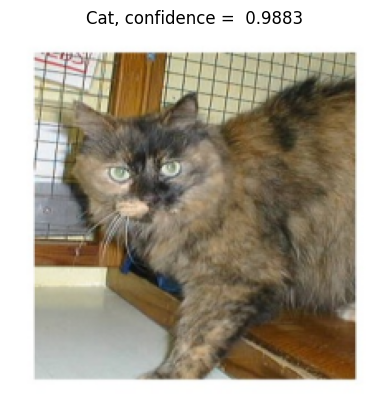

In [18]:
while True:
    # Look for a cat
    idx = np.random.randint(0, len(train_set))
    if train_set[idx][1] != 0:
        continue
    cat_image = train_set[idx][0]
    break

# Allow gradient computation for the image
cat_image.requires_grad = True

pred = model(cat_image[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.axis("off")
plt.imshow(cat_image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

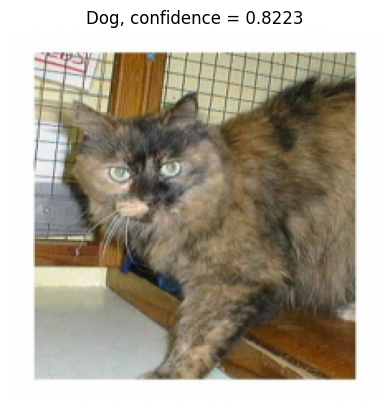

In [19]:
loss = nn.CrossEntropyLoss()(pred, torch.tensor(0).reshape((1,)))
loss.backward()

eps = 0.007

cat_image_perturbated = fgsm_attack(cat_image, eps, cat_image.grad)
pred = model(cat_image_perturbated[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

plt.axis("off")
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(cat_image_perturbated.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

The most interesting part starts here. Calculate the gradient of the loss function with respect to the image and perform the attack.


## 3. Visualizing Convolutional Network Layers Using Shapley Additive Explanations

![SHAP Header](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg)

**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

Let's imagine that a prediction is the result of a team game, and we need to understand how much each player (feature) contributed to the result.

The contribution of each feature is measured by the so-called **Shapley value** - a concept from cooperative game theory that describes the contribution of a feature to a prediction.

For example, you rent a one-room apartment and want to create a model that predicts the cost of your chosen option. For a given apartment, the model predicted a price of 1,000 euros. The apartment's features that influenced the predicted price include being within the metro station, having air conditioning, not allowing home crocodiles, and being near a park. We need to find the **Shapley value** of the "not allowing home crocodiles" feature to understand how much this particular feature contributes.

The **Shapley value** is the average of possible **marginal contributions**. We create all possible sets over the feature set, excluding the one of interest ("not allowing home crocodiles"):

- no features
- within metro
- air conditioning
- near a park
- within metro, air conditioning
- within metro, near a park
- air conditioning, near a park
- within metro, near a park, air conditioning

Example for marginal contribution:

**Marginal contribution** = *model_predict* (within metro, near a park, not allowing home crocodiles) - *model_predict* (within metro, near a park)

$$
\Phi(v)_i=\sum_{K \ni i} \frac{(k-1) !(n-k) !}{n !}(v(K)-v(K \backslash i))
$$

Where: $n$ is the number of players (in our case, the features of the model). $v$ is the model's prediction on the feature set. $k$ is the number of participants in the coalition $K$.

We can explain the prediction by assuming that each feature is a "player" in a game where the prediction is the payout. Shapley values, a method from coalition game theory, tell us how to fairly distribute the "payout" among the features.

Documentation available [here](https://shap.readthedocs.io/en/latest/).


In [20]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.0 MB/s eta 0:00:00


In [21]:
import json

import shap

### Exploring ResNet Layers on ImageNet Data

Interpreting predictions based on the original image is simpler than interpreting the layers closest to the network's output because the latter are less interpretable. Each level in a deep CNN learns filters of increasing complexity. Basic object detection filters, such as edges and corners, are learned in the early layers. Intermediate layers learn filters that detect parts of objects — in the case of faces, they might learn to respond to eyes and noses. The final layers have higher-level representations: they learn to recognize whole objects in various forms and positions.

We will examine the GradientExplainer model, which uses expected gradients to assess inputs to different parts of the model. In general, they approximate SHAP values. We will take 50 samples for calculating expected gradients and examine the features of the first layers of ResNet.


In [22]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll axes so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [23]:
# Load proper model (resnet50) and data (imagenet50) from Shap wrapper
model = resnet18(pretrained=True).eval()
X, y = shap.datasets.imagenet50()
X /= 255

to_explain = X[[1, 41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)

with open(fname) as f:
    class_names = json.load(f)

#### Layer 1

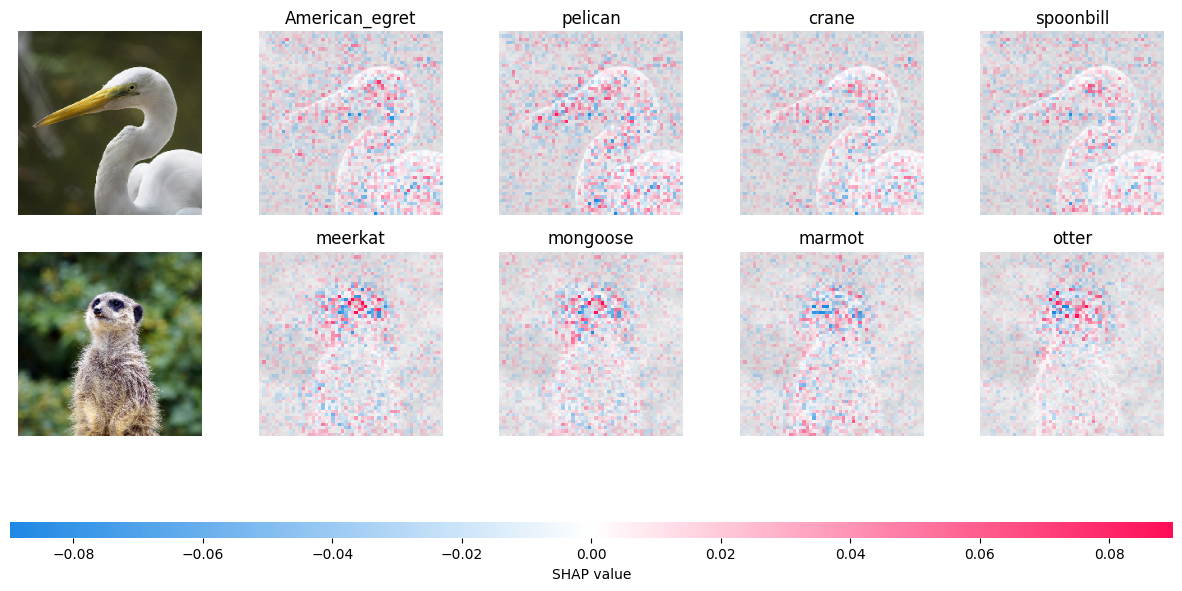

In [24]:
# create GradientExplainer object for convolution layer from Resnet Layer1
e = shap.GradientExplainer((model, model.layer1[0].conv2), normalize(X))
# receive shap_values
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

#### Layer 2

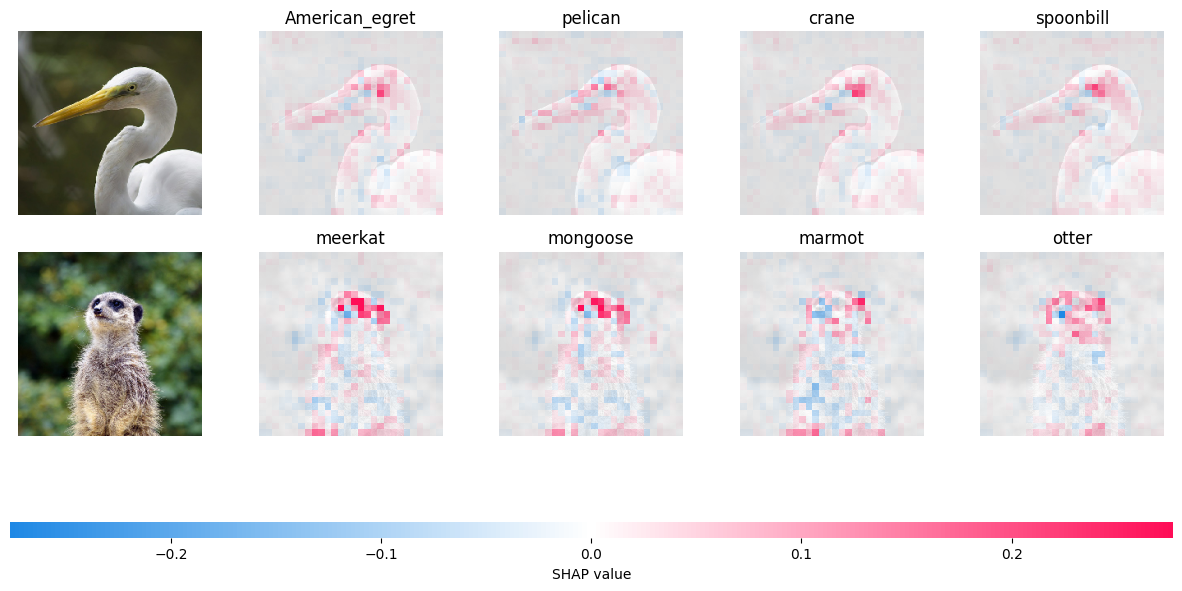

In [25]:
e = shap.GradientExplainer((model, model.layer2[0].conv2), normalize(X))
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)

#### Layer 4

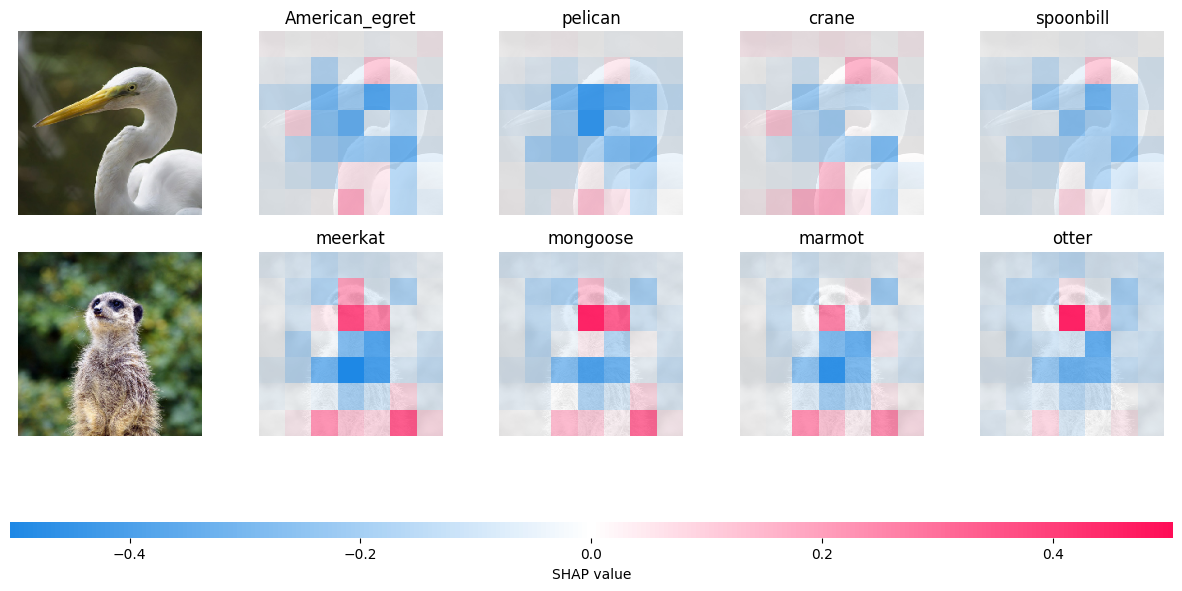

In [26]:
e = shap.GradientExplainer((model, model.layer4[0].conv2), normalize(X))
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=4, nsamples=50
)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)